In [1]:
import glob
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import gpytorch

from sklearn.preprocessing import StandardScaler
from math import floor, ceil
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import (
    Input,
    Dense,
    Lambda,
    Flatten,
    Reshape,
)
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from natsort import natsorted

In [2]:
np.random.seed(10)
tf.random.set_seed(10)

plt.style.use("ggplot")

In [3]:
def reduce_series(variable: str):
    eta_paths = natsorted(glob.glob(f"data/{variable}*.npy"))
    array_list = []
    for path in eta_paths:
        array = np.load(path)
        array_list.append(array)
    np.save(f"series_{variable}.npy", array_list)


def make_svd(variable: str):
    x = np.load(f"series_{variable}.npy")
    x_new = np.transpose(x, (1, 0, 2, 3))
    x_new = x_new.reshape(-1, x.shape[2] * x.shape[3])
    U, S, VT = np.linalg.svd(x_new, full_matrices=False)

    np.save("PCA_Vectors.npy", VT.T)
    np.save("PCA_Coefficients.npy", (U * S).T)

In [4]:
series = "zvals"

reduce_task = reduce_series(series)
svd_task = make_svd(series)

num_modes = 5
compression = "CAE"
split = [5]
num_epochs = 1000
batch_size = 4

In [5]:
eta_paths = natsorted(glob.glob("data/zvals*.npy"))

Res = np.zeros(len(eta_paths))

for path in range(len(eta_paths)):
    Res[path] = float(re.findall("\d+(?:\.\d+)?", eta_paths[path].split("_")[1])[0])

num_sims = len(eta_paths)
pick = np.load(eta_paths[0]).shape
num_tsteps = pick[0]
dim = pick[1]

eta_vector = Res

In [6]:
def sampling(args):

    epsilon_mean = 0.1
    epsilon_std = 1e-4

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=epsilon_mean, stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
intevals = num_tsteps

pca_vectors = np.load("PCA_Vectors.npy")
pca_coeffs = np.load("PCA_Coefficients.npy") 

field_keep = []
for nu in range(num_sims):
    for time in range(intevals):
        field_keep.append(
            np.matmul(
                pca_vectors,
                pca_coeffs[:, (num_sims * time + nu) : (num_sims * time + nu + 1),],
            )
        )
swe_data = np.squeeze(field_keep)

preproc = Pipeline([("stdscaler", StandardScaler())])

In [8]:
if isinstance(split, float):
    swe_train = preproc.fit_transform(swe_data[: floor(split * swe_data.shape[0]), :])
    swe_valid = preproc.transform(swe_data[floor(split * swe_data.shape[0]) :, :])
    swe_train = swe_train.reshape(
        floor(split * swe_data.shape[0]), dim, dim, 1
    )
    swe_valid = swe_valid.reshape(
        ceil(round((1 - split), 2) * swe_data.shape[0]), dim, dim, 1
    )
elif isinstance(split, list):
    swe_train = preproc.fit_transform(
        np.delete(
            swe_data, np.s_[split[0] * intevals : (split[-1] + 1) * intevals], axis=0,
        )
    )
    swe_valid = preproc.transform(
        swe_data[split[0] * intevals : (split[-1] + 1) * intevals, :]
    )
    swe_train = swe_train.reshape(-1, dim, dim, 1)
    swe_valid = swe_valid.reshape(-1, dim, dim, 1)

In [9]:
swe_train_data = np.copy(swe_train)
swe_valid_data = np.copy(swe_valid)

np.random.shuffle(swe_train_data)
np.random.shuffle(swe_valid_data)

In [10]:
weights_filepath = "best_weights_" + compression + ".h5"
lrate = 0.001

## Encoder
encoder_inputs = Input(shape=(dim, dim, 1), name="Field")
# Encode
x = Conv2D(30, kernel_size=(3, 3), activation="relu", padding="same")(encoder_inputs)
enc_l2 = MaxPooling2D(pool_size=(2, 2), padding="same")(x)

x = Conv2D(25, kernel_size=(3, 3), activation="relu", padding="same")(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2), padding="same")(x)

x = Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same")(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2), padding="same")(x)

x = Conv2D(15, kernel_size=(3, 3), activation="relu", padding="same")(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2), padding="same")(x)

x = Conv2D(10, kernel_size=(3, 3), activation=None, padding="same")(enc_l5)
x = MaxPooling2D(pool_size=(2, 2), padding="same")(x)

x = Flatten()(x)

if compression == "CAE":
    encoded = Dense(num_modes, activation=None)(x)
    encoder = Model(inputs=encoder_inputs, outputs=encoded)
elif compression == "VAE":
    z_mean = Dense(num_modes, name="z_mean")(x)
    z_log_var = Dense(num_modes, name="z_log_var")(x)
    z = Lambda(sampling, output_shape=(num_modes,), name="z")([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

## Decoder
decoder_inputs = Input(shape=(num_modes,), name="decoded")
x = Dense(8, activation=None)(decoder_inputs)
x = Reshape(target_shape=(2, 2, 2))(x)

x = Conv2D(10, kernel_size=(3, 3), activation=None, padding="same")(x)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(15, kernel_size=(3, 3), activation="relu", padding="same")(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20, kernel_size=(3, 3), activation="relu", padding="same")(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(25, kernel_size=(3, 3), activation="relu", padding="same")(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30, kernel_size=(3, 3), activation="relu", padding="same")(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

decoded = Conv2D(1, kernel_size=(3, 3), activation=None, padding="same")(dec_l5)
decoder = Model(inputs=decoder_inputs, outputs=decoded)

## Autoencoder
ae_outputs = decoder(encoder(encoder_inputs))
model = Model(inputs=encoder_inputs, outputs=ae_outputs, name=compression)

# design network
my_adam = optimizers.Adam(
    lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
)

if compression == "CAE":
    model.compile(
        optimizer=my_adam, loss="mean_squared_error"
    )
elif compression == "VAE":
    reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(ae_outputs))
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    model.add_loss(vae_loss)
    model.compile(optimizer=my_adam, metrics=[coeff_determination])

checkpoint = ModelCheckpoint(
    weights_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)

earlystopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

callbacks_list = [checkpoint, earlystopping]

val_split = 0.9

In [12]:
train_history = model.fit(
    x=swe_train_data,
    y=swe_train_data,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    validation_split=val_split,
    verbose=0
)


Epoch 00001: val_loss improved from 0.30764 to 0.16818, saving model to best_weights_CAE.h5

Epoch 00002: val_loss did not improve from 0.16818

Epoch 00003: val_loss improved from 0.16818 to 0.15776, saving model to best_weights_CAE.h5

Epoch 00004: val_loss improved from 0.15776 to 0.11417, saving model to best_weights_CAE.h5

Epoch 00005: val_loss improved from 0.11417 to 0.10045, saving model to best_weights_CAE.h5

Epoch 00006: val_loss improved from 0.10045 to 0.09550, saving model to best_weights_CAE.h5

Epoch 00007: val_loss improved from 0.09550 to 0.07797, saving model to best_weights_CAE.h5

Epoch 00008: val_loss improved from 0.07797 to 0.07762, saving model to best_weights_CAE.h5

Epoch 00009: val_loss improved from 0.07762 to 0.06832, saving model to best_weights_CAE.h5

Epoch 00010: val_loss did not improve from 0.06832

Epoch 00011: val_loss did not improve from 0.06832

Epoch 00012: val_loss did not improve from 0.06832

Epoch 00013: val_loss improved from 0.06832 to 


Epoch 00135: val_loss did not improve from 0.01969

Epoch 00136: val_loss did not improve from 0.01969

Epoch 00137: val_loss did not improve from 0.01969

Epoch 00138: val_loss did not improve from 0.01969

Epoch 00139: val_loss did not improve from 0.01969

Epoch 00140: val_loss did not improve from 0.01969

Epoch 00141: val_loss did not improve from 0.01969

Epoch 00142: val_loss did not improve from 0.01969

Epoch 00143: val_loss improved from 0.01969 to 0.01957, saving model to best_weights_CAE.h5

Epoch 00144: val_loss did not improve from 0.01957

Epoch 00145: val_loss did not improve from 0.01957

Epoch 00146: val_loss did not improve from 0.01957

Epoch 00147: val_loss did not improve from 0.01957

Epoch 00148: val_loss did not improve from 0.01957

Epoch 00149: val_loss did not improve from 0.01957

Epoch 00150: val_loss did not improve from 0.01957

Epoch 00151: val_loss did not improve from 0.01957

Epoch 00152: val_loss did not improve from 0.01957

Epoch 00153: val_loss 

In [13]:
if compression == "CAE":
    encoded_t = K.eval(encoder(swe_train[:, :, :, :].astype("float32")))
    encoded_v = K.eval(encoder(swe_valid[:, :, :, :].astype("float32")))
elif compression == "VAE":
    encoded_t = K.eval(encoder(swe_train[:, :, :, :].astype("float32")))[0].numpy()
    encoded_v = K.eval(encoder(swe_valid[:, :, :, :].astype("float32")))[0].numpy()

if isinstance(split, float):
    encoded_t = encoded_t.reshape(floor(split * swe_data.shape[0]), num_modes)
    encoded_v = encoded_v.reshape(
        ceil(round((1 - split), 2) * swe_data.shape[0]), num_modes
    )
elif isinstance(split, list):
    encoded_t = encoded_t.reshape(-1, num_modes)
    encoded_v = encoded_v.reshape(-1, num_modes)

encoded = np.concatenate((encoded_t, encoded_v), axis=0)
model.load_weights(weights_filepath)

np.save(compression + "_Coefficient_Training_Data" + str(num_modes) + ".npy", encoded)


comp_data = np.load(
    compression + "_Coefficient_Training_Data" + str(num_modes) + ".npy"
)

intevals = num_tsteps

if isinstance(split, float):
    num_train_sims = floor(split * num_sims)
    num_test_sims = ceil(round((1 - split), 2) * num_sims)
    training_d = comp_data[: num_train_sims * num_tsteps, :]
    testing_d = comp_data[num_train_sims * num_tsteps :, :]
elif isinstance(split, list):
    num_train_sims = np.delete(np.arange(num_sims), split).size
    num_test_sims = len(split)
    training_d = np.delete(
        comp_data, np.s_[split[0] * num_tsteps : (split[-1] + 1) * num_tsteps], axis=0,
    )
    testing_d = comp_data[split[0] * num_tsteps : (split[-1] + 1) * num_tsteps, :]

raw_training = training_d.reshape(num_train_sims, num_tsteps, num_modes)
raw_testing = testing_d.reshape(num_test_sims, num_tsteps, num_modes)

ic_info = np.zeros(shape=(num_sims, 1))
ic_info[:, 0] = eta_vector

if isinstance(split, float):
    B = np.tile(ic_info[:num_train_sims], (num_tsteps, 1, 1)).transpose(1, 0, 2)
    BB = np.tile(ic_info[num_train_sims:], (num_tsteps, 1, 1)).transpose(1, 0, 2)
elif isinstance(split, list):
    B = np.tile(
        ic_info[np.delete(np.arange(num_sims), split)], (num_tsteps, 1, 1)
    ).transpose(1, 0, 2)
    BB = np.tile(ic_info[split], (num_tsteps, 1, 1)).transpose(1, 0, 2)

raw_training = np.concatenate([raw_training, B], axis=-1)
raw_testing = np.concatenate([raw_testing, BB], axis=-1)

raw_training_data = raw_training
num_simulations = np.shape(raw_training_data)[0]
num_data_points = np.shape(raw_training_data)[0] * np.shape(raw_training_data)[1]
num_timesteps_per_simulation = np.shape(raw_training_data)[1]
state_len = np.shape(raw_training_data)[-1]

In [14]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood(
)

In [17]:
def fit_all():

    m1_list = []
    for dim in range(num_modes):
        print(dim)

        df_all = pd.DataFrame(columns=["X1", "X2", "Y"])
        for i in range(num_simulations):
            series = raw_training_data[i, :, dim]
            df = pd.DataFrame()
            df["X1"] = list(np.linspace(0, 1, len(series)))
            df["X2"] = raw_training_data[i, :, -1]
            df["Y"] = list(series)
            df_all = pd.concat([df_all, df], ignore_index=True)

        # Train and test data as numpy arrays
        X = df_all[["X1", "X2"]].to_numpy()
        Y1 = df_all["Y"].to_numpy().reshape(-1, 1)

        train_x = torch.from_numpy(X).float()
        train_y = torch.from_numpy(Y1.reshape(-1)).float()

        model = ExactGPModel(train_x, train_y, likelihood)

        model.train()
        likelihood.train()

        hypers = {
            "covar_module.base_kernel.lengthscale": torch.tensor([0.01, 1.0]),
        }

        model.initialize(**hypers)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        training_iter = 1000

        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        patience = 50
        min_delta = 0.001
        counter = 0
        best_loss = None

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", patience=20, factor=0.1, min_lr=1e-6, verbose=True
        )

        for i in range(training_iter):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()
            lr_scheduler.step(loss)

            if i == 0:
                best_loss = loss
            elif best_loss - loss > min_delta:
                counter = 0
#                 print(
#                     f"Iter {i}/{training_iter} - Validation loss decreased ({round(best_loss.item(),3)} --> {round(loss.item(),3)})."
#                 )
                best_loss = loss
                torch.save(model.state_dict(), "model_state" + str(dim) + ".pth")
            elif best_loss - loss < min_delta:
                counter += 1
#                 print(
#                     f"Iter {i}/{training_iter} - Early stopping counter {counter} of {patience}"
#                 )
                if counter >= patience:
                    break

        model.load_state_dict(torch.load("model_state" + str(dim) + ".pth"))

        m1_list.append(model)

    return m1_list

In [18]:
m1_list = fit_all()

0
Epoch   335: reducing learning rate of group 0 to 1.0000e-03.
Epoch   369: reducing learning rate of group 0 to 1.0000e-04.
Epoch   397: reducing learning rate of group 0 to 1.0000e-05.
Epoch   418: reducing learning rate of group 0 to 1.0000e-06.
1
Epoch   295: reducing learning rate of group 0 to 1.0000e-03.
Epoch   319: reducing learning rate of group 0 to 1.0000e-04.
Epoch   340: reducing learning rate of group 0 to 1.0000e-05.
2
Epoch   268: reducing learning rate of group 0 to 1.0000e-03.
3
Epoch   298: reducing learning rate of group 0 to 1.0000e-03.
Epoch   319: reducing learning rate of group 0 to 1.0000e-04.
4
Epoch   280: reducing learning rate of group 0 to 1.0000e-03.
Epoch   301: reducing learning rate of group 0 to 1.0000e-04.


In [19]:
import pickle

with open("GP_info.txt", "wb") as fp:  # Pickling
    pickle.dump(m1_list, fp)

with open("GP_info.txt", "rb") as fp:  # Unpickling
    m1_list = pickle.load(fp)

In [20]:
def test_all(m1_list, sim_num):

    viz_list = []
    var_list = []
    for dim in range(num_modes):

        # Test dataset
        raw_testing_data = raw_testing
        series = raw_testing_data[sim_num, :, dim]
        df_test = pd.DataFrame()
        df_test["X1"] = list(np.linspace(0, 1, len(series)))
        df_test["X2"] = raw_testing_data[sim_num, :, -1]
        df_test["Y"] = list(series)

        X_test = df_test[["X1", "X2"]].to_numpy()
        Y1_test = df_test["Y"].to_numpy().reshape(-1, 1)

        # Predict
        xx = X_test

        model_test = m1_list[dim]
        model_test.eval()
        model_test.likelihood.eval()

        f_preds = model_test(torch.from_numpy(xx).float())

        mean = f_preds.mean.detach().numpy()
        var = f_preds.variance.detach().numpy()

        viz_list.append(mean)
        var_list.append(var)

    return np.array(viz_list).T, np.array(var_list).T

In [21]:
for sim_num in range(num_test_sims):
    test_fit_mean, test_fit_var = test_all(m1_list, sim_num)

    np.save(compression + "_GP_" + str(sim_num) + ".npy", test_fit_mean)
    np.save(compression + "_GP_Var_" + str(sim_num) + ".npy", test_fit_var)

for sim_num in range(num_test_sims):

    comp_pred = np.load(compression + "_GP_" + str(sim_num) + ".npy").astype("float32")
    true = swe_valid[sim_num * num_tsteps : (sim_num + 1) * num_tsteps]

    rec_pred = comp_pred.reshape(num_tsteps, num_modes)

    gp_recoded = K.eval(decoder(rec_pred))
    gp_recoded = preproc.inverse_transform(
        gp_recoded.reshape(num_tsteps, dim * dim)
    ).reshape(num_tsteps, dim, dim)

    full_true = preproc.inverse_transform(true.reshape(num_tsteps, dim * dim)).reshape(
        num_tsteps, dim, dim
    )

    for time in range(0, intevals):
        rec_pred = comp_pred[time, :].reshape(1, num_modes)
        full_true = true[time]

        gp_recoded = K.eval(decoder(rec_pred))
        gp_recoded = preproc.inverse_transform(
            gp_recoded.reshape(1, dim * dim)
        ).reshape(dim, dim)

        full_true = preproc.inverse_transform(full_true.reshape(1, dim * dim)).reshape(
            dim, dim
        )

        np.save(
            compression + "_data/" + compression + "_True_" + str(time) + ".npy",
            full_true,
        )
        np.save(
            compression + "_data/" + compression + "_Rec_GP_" + str(time) + ".npy",
            gp_recoded,
        )

In [22]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

gp_mae_score_val = 0.0
gp_mse_score_val = 0.0

for sim_num in range(num_test_sims):

    comp_pred = np.load(compression + "_GP_" + str(sim_num) + ".npy").astype("float32")

    true = swe_valid[sim_num * num_tsteps : (sim_num + 1) * num_tsteps]

    rec_pred = comp_pred.reshape(num_tsteps, num_modes)

    gp_recoded = K.eval(decoder(rec_pred))
    gp_recoded = preproc.inverse_transform(
        gp_recoded.reshape(num_tsteps, dim * dim)
    ).reshape(num_tsteps, dim, dim)

    full_true = preproc.inverse_transform(true.reshape(num_tsteps, dim * dim)).reshape(
        num_tsteps, dim, dim
    )

    gp_mae_score_val = gp_mae_score_val + mean_squared_error(
        gp_recoded.flatten(), full_true.flatten()
    )
    gp_mse_score_val = gp_mse_score_val + mean_absolute_error(
        gp_recoded.flatten(), full_true.flatten()
    )

with open("metrics.txt", "a") as text_file:
    print(f"Metrics for {compression} recreation (AE + GP):", file=text_file)
    print(f"GP MAE score: {gp_mae_score_val/50.0}", file=text_file)
    print(f"GP MSE score: {gp_mse_score_val/50.0}", file=text_file)

In [38]:
from torch.nn import Linear
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL
from natsort import natsorted

from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy

from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Lambda,
    Dropout,
    Flatten,
    Reshape,
    Conv2DTranspose,
)

In [24]:
class ToyDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type="constant"):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )

        super(ToyDeepGPHiddenLayer, self).__init__(
            variational_strategy, input_dims, output_dims
        )

        if mean_type == "constant":
            self.mean_module = ConstantMean()
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            MaternKernel(nu=1.5, ard_num_dims=input_dims),
            ard_num_dims=None,
        )

        self.linear_layer = Linear(input_dims, 1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


num_output_dims = 2


class DeepGP(DeepGP):
    def __init__(self, train_x_shape):
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_output_dims,
            mean_type="linear",
        )

        last_layer = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims, output_dims=None, mean_type="constant",
        )

        super().__init__()

        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()

    def forward(self, inputs):
        hidden_rep = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep)
        return output

    def predict(self, x_test):
        with torch.no_grad():
            mus = []
            variances = []
            preds = model.likelihood(model(x_test))
            mus.append(preds.mean)
            variances.append(preds.variance)

        return (
            torch.cat(mus, dim=-1),
            torch.cat(variances, dim=-1),
        )

In [28]:
def fit_all():

    m1_list = []
    for dim in range(num_modes):
        print(dim)

        df_all = pd.DataFrame(columns=["X1", "X2", "Y"])
        for i in range(num_simulations):
            series = raw_training_data[i, :, dim]
            df = pd.DataFrame()
            df["X1"] = list(np.linspace(0, 1, len(series)))
            df["X2"] = raw_training_data[i, :, -1]
            df["Y"] = list(series)
            df_all = pd.concat([df_all, df], ignore_index=True)

        X = df_all[["X1", "X2"]].to_numpy()
        Y1 = df_all["Y"].to_numpy().reshape(-1, 1)

        train_x = torch.from_numpy(X).float()
        train_y = torch.from_numpy(Y1.reshape(-1)).float()

        model = DeepGP(train_x.shape)

        hypers = {
            "hidden_layer.covar_module.base_kernel.lengthscale": torch.tensor(
                [100.0, 100.0]
            ),
            "last_layer.covar_module.base_kernel.lengthscale": torch.tensor(
                [100, 100.0]
            ),
        }

        model.initialize(**hypers)

        model.train()

        mll = DeepApproximateMLL(
            VariationalELBO(model.likelihood, model, train_x.shape[-2])
        )

        training_iter = 10000

        optimizer = torch.optim.Adam([{"params": model.parameters()},], lr=0.1)

        patience = 50
        min_delta = 0.001
        counter = 0
        best_loss = None

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", patience=20, factor=0.1, min_lr=1e-6, verbose=True
        )

        for i in range(training_iter):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()
            lr_scheduler.step(loss)

            if i == 0:
                best_loss = loss
            elif best_loss - loss > min_delta:
                counter = 0
#                 print(
#                     f"Iter {i}/{training_iter} - Validation loss decreased ({round(best_loss.item(),3)} --> {round(loss.item(),3)})."
#                 )
                best_loss = loss
                torch.save(model.state_dict(), "model_state" + str(dim) + ".pth")
            elif best_loss - loss < min_delta:
                counter += 1
#                 print(
#                     f"Iter {i}/{training_iter} - Early stopping counter {counter} of {patience}"
#                 )
                if counter >= patience:
                    break

        model.load_state_dict(torch.load("model_state" + str(dim) + ".pth"))

        m1_list.append(model)

    return m1_list

In [29]:
m1_list = fit_all()

0
Epoch   658: reducing learning rate of group 0 to 1.0000e-02.
1
Epoch   518: reducing learning rate of group 0 to 1.0000e-02.
2
Epoch   384: reducing learning rate of group 0 to 1.0000e-02.
3
Epoch   488: reducing learning rate of group 0 to 1.0000e-02.
Epoch   509: reducing learning rate of group 0 to 1.0000e-03.
4
Epoch   320: reducing learning rate of group 0 to 1.0000e-02.
Epoch   394: reducing learning rate of group 0 to 1.0000e-03.
Epoch   442: reducing learning rate of group 0 to 1.0000e-04.
Epoch   473: reducing learning rate of group 0 to 1.0000e-05.
Epoch   494: reducing learning rate of group 0 to 1.0000e-06.


In [30]:
def test_all(m1_list, sim_num):

    viz_list = []
    var_list = []
    for dim in range(num_modes):

        # Test dataset
        raw_testing_data = raw_testing
        series = raw_testing_data[sim_num, :, dim]
        df_test = pd.DataFrame()
        df_test["X1"] = list(np.linspace(0, 1, len(series)))
        df_test["X2"] = raw_testing_data[sim_num, :, -1]
        df_test["Y"] = list(series)

        X_test = df_test[["X1", "X2"]].to_numpy()
        Y1_test = df_test["Y"].to_numpy().reshape(-1, 1)

        # Predict
        xx = X_test

        model_test = m1_list[dim]

        mod = model_test.eval()

        mean = (
            mod.likelihood(mod(torch.from_numpy(xx).float())).mean[0].detach().numpy()
        )
        var = (
            mod.likelihood(mod(torch.from_numpy(xx).float()))
            .variance[0]
            .detach()
            .numpy()
        )

        viz_list.append(mean)
        var_list.append(var)

    return np.array(viz_list).T, np.array(var_list).T

In [31]:
for sim_num in range(num_test_sims):
    test_fit_mean, test_fit_var = test_all(m1_list, sim_num)

    np.save(compression + "_DGP_" + str(sim_num) + ".npy", test_fit_mean)
    np.save(compression + "_DGP_Var_" + str(sim_num) + ".npy", test_fit_var)

dim = 64

for sim_num in range(num_test_sims):

    comp_pred = np.load(compression + "_DGP_" + str(sim_num) + ".npy").astype("float32")

    true = swe_valid[sim_num * num_tsteps : (sim_num + 1) * num_tsteps]

    rec_pred = comp_pred.reshape(num_tsteps, num_modes)

    gp_recoded = K.eval(decoder(rec_pred))
    gp_recoded = preproc.inverse_transform(
        gp_recoded.reshape(num_tsteps, dim * dim)
    ).reshape(num_tsteps, dim, dim)

    full_true = preproc.inverse_transform(true.reshape(num_tsteps, dim * dim)).reshape(
        num_tsteps, dim, dim
    )

    for time in range(0, intevals):
        rec_pred = comp_pred[time, :].reshape(1, num_modes)
        full_true = true[time]

        gp_recoded = K.eval(decoder(rec_pred))
        gp_recoded = preproc.inverse_transform(
            gp_recoded.reshape(1, dim * dim)
        ).reshape(dim, dim)

        full_true = preproc.inverse_transform(full_true.reshape(1, dim * dim)).reshape(
            dim, dim
        )

        np.save(
            compression + "_data/" + compression + "_DTrue_" + str(time) + ".npy",
            full_true,
        )
        np.save(
            compression + "_data/" + compression + "_DRec_GP_" + str(time) + ".npy",
            gp_recoded,
        )

In [32]:
dgp_mae_score_val = 0.0
dgp_mse_score_val = 0.0

for sim_num in range(num_test_sims):

    comp_pred = np.load(compression + "_DGP_" + str(sim_num) + ".npy").astype("float32")

    true = swe_valid[sim_num * num_tsteps : (sim_num + 1) * num_tsteps]

    rec_pred = comp_pred.reshape(num_tsteps, num_modes)

    dgp_recoded = K.eval(decoder(rec_pred))
    dgp_recoded = preproc.inverse_transform(
        dgp_recoded.reshape(num_tsteps, dim * dim)
    ).reshape(num_tsteps, dim, dim)

    full_true = preproc.inverse_transform(true.reshape(num_tsteps, dim * dim)).reshape(
        num_tsteps, dim, dim
    )

    dgp_mae_score_val = dgp_mae_score_val + mean_squared_error(
        dgp_recoded.flatten(), full_true.flatten()
    )
    dgp_mse_score_val = dgp_mse_score_val + mean_absolute_error(
        dgp_recoded.flatten(), full_true.flatten()
    )

with open("metrics.txt", "a") as text_file:
    print(f"Metrics for {compression} recreation (AE + DGP):", file=text_file)
    print(f"DGP MAE score: {dgp_mae_score_val/50.0}", file=text_file)
    print(f"DGP MSE score: {dgp_mse_score_val/50.0}", file=text_file)

In [34]:
comp_data = np.load(
    compression + "_Coefficient_Training_Data" + str(num_modes) + ".npy"
)

intevals = num_tsteps

num_train_sims = num_sims - 1
num_test_sims = 1  # 1
training_d = np.delete(
    comp_data, np.s_[split[0] * intevals : (split[-1] + 1) * intevals], axis=0,
)
testing_d = comp_data[split[0] * intevals : (split[-1] + 1) * intevals, :]

raw_training = training_d.reshape(num_train_sims, num_tsteps, num_modes)
raw_testing = testing_d.reshape(num_test_sims, num_tsteps, num_modes)

ic_info = np.zeros(shape=(num_sims, 1))
ic_info[:, 0] = eta_vector

B = np.tile(
    ic_info[np.delete(np.arange(num_sims), split)], (num_tsteps, 1, 1)
).transpose(1, 0, 2)
BB = np.tile(ic_info[split], (num_tsteps, 1, 1)).transpose(1, 0, 2)

raw_training = np.concatenate([raw_training, B], axis=-1)
raw_testing = np.concatenate([raw_testing, BB], axis=-1)

raw_training_data = raw_training
num_simulations = np.shape(raw_training_data)[0]
num_data_points = np.shape(raw_training_data)[0] * np.shape(raw_training_data)[1]
num_timesteps_per_simulation = np.shape(raw_training_data)[1]
state_len = np.shape(raw_training_data)[-1]

encoded = comp_data

In [39]:
num_train_snapshots = 19
num_test_snapshots = num_sims - num_train_snapshots
lstm_training_data = raw_training_data
time_window = 10

total_size = np.shape(lstm_training_data)[0] * np.shape(lstm_training_data)[1]
total_size_sim = np.shape(lstm_training_data)[1]

input_seq = np.zeros(
    shape=(total_size - num_train_snapshots * time_window, time_window, num_modes + 1)
)
output_seq = np.zeros(shape=(total_size - num_train_snapshots * time_window, num_modes))

# Setting up inputs
sample = 0
for snum in range(num_train_snapshots):
    for t in range(time_window, total_size_sim):
        input_seq[sample, :, :] = lstm_training_data[snum, t - time_window : t, :]
        output_seq[sample, :] = lstm_training_data[snum, t, 0:num_modes]
        sample = sample + 1

# Model architecture
lstm_model = models.Sequential()
lstm_model.add(
    LSTM(50, input_shape=(time_window, num_modes + 1), return_sequences=True)
)
lstm_model.add(
    LSTM(50, input_shape=(time_window, num_modes + 1), return_sequences=True)
)
lstm_model.add(
    LSTM(50, input_shape=(time_window, num_modes + 1), return_sequences=False)
)
lstm_model.add(Dense(num_modes, activation=None))

# training parameters
num_epochs = 3000
batch_size = 32

# design network
lstm_filepath = "lstm_weights.h5"
lstm_adam = optimizers.Adam(
    lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
)
checkpoint = ModelCheckpoint(
    lstm_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
earlystopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
lstm_callbacks_list = [checkpoint, earlystopping]

# fit network
lstm_model.compile(
    optimizer=lstm_adam, loss="mean_squared_error",
)

In [40]:
lstm_train_history = lstm_model.fit(
    input_seq,
    output_seq,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=lstm_callbacks_list,
    validation_split=0.1,
    verbose = 0
)

In [41]:
lstm_testing_data = raw_testing

total_size = np.shape(lstm_testing_data)[0] * np.shape(lstm_testing_data)[1]
total_size_sim = np.shape(lstm_testing_data)[1]

# Shape the inputs and outputs
input_seq = np.zeros(shape=(1, time_window, num_modes + 1))
output_seq = np.zeros(shape=(total_size - num_test_snapshots * time_window, num_modes))
output_seq_pred = np.zeros(
    shape=(total_size - num_test_snapshots * time_window, num_modes)
)

# Setting up inputs
sample = 0
for snum in range(num_test_snapshots):
    input_seq[0, :, :] = lstm_testing_data[snum, 0:time_window, :]
    for t in range(time_window, total_size_sim):
        output_seq_pred[sample, :] = lstm_model.predict(input_seq[0:1, :, :])[0, :]
        output_seq[sample, :] = lstm_testing_data[snum, t, 0:num_modes]
        input_seq[0, 0 : time_window - 1, :] = input_seq[0, 1:, :]
        input_seq[0, time_window - 1, :num_modes] = output_seq_pred[sample, :]
        sample = sample + 1

decoded_valid = K.eval(decoder(output_seq_pred))
decoded_valid = preproc.inverse_transform(
    decoded_valid.reshape(num_tsteps - time_window, dim * dim)
).reshape(num_tsteps - time_window, dim, dim)

for time in range(0, intevals - time_window):
    np.save(
        compression + "_data/" + compression + "_lstm_" + str(time) + ".npy",
        decoded_valid[time, :, :].reshape(64, 64),
    )

In [42]:
lstm_mae_score_val = 0.0
lstm_mse_score_val = 0.0

for sim_num in range(num_test_sims):

    true = swe_valid[sim_num * num_tsteps : (sim_num + 1) * num_tsteps]

    rec_pred = comp_pred.reshape(num_tsteps, num_modes)

    full_true = preproc.inverse_transform(true.reshape(num_tsteps, dim * dim)).reshape(
        num_tsteps, dim, dim
    )

    full_true_lstm = full_true[time_window:]

    lstm_recoded = decoded_valid

    lstm_mae_score_val = lstm_mae_score_val + mean_squared_error(
        lstm_recoded.flatten(), full_true_lstm.flatten()
    )
    lstm_mse_score_val = lstm_mse_score_val + mean_absolute_error(
        lstm_recoded.flatten(), full_true_lstm.flatten()
    )

with open("metrics.txt", "a") as text_file:
    print(f"Metrics for {compression} recreation (AE + LSTM):", file=text_file)
    print(f"LSTM MAE score: {lstm_mae_score_val/40.0}", file=text_file) # /40 because of the time window
    print(f"LSTM MSE score: {lstm_mse_score_val/40.0}", file=text_file)

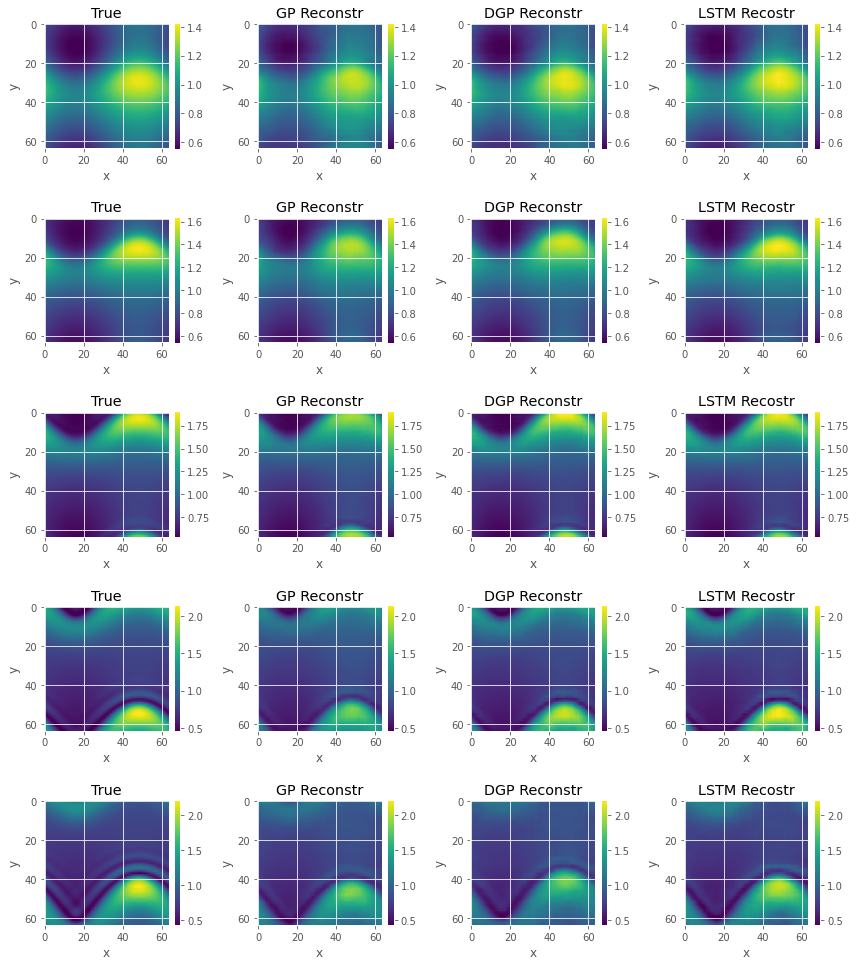

In [43]:
plot_picks = [0, 10, 20, 30, 39]
plot_range = len(plot_picks)

fig = plt.figure(figsize=(12, 3 * plot_range))

for ii, time in enumerate(plot_picks):
    ttime = 10 + time

    full_true = np.load(
        compression + "_data/" + compression + "_True_" + str(ttime) + ".npy"
    )
    dgp_recoded = np.load(
        compression + "_data/" + compression + "_DRec_GP_" + str(ttime) + ".npy"
    )
    gp_recoded = np.load(
        compression + "_data/" + compression + "_Rec_GP_" + str(ttime) + ".npy"
    )

    lstm_recoded = np.load(
        compression + "_data/" + compression + "_lstm_" + str(time) + ".npy"
    )

    all_max = max(
        full_true.max(), dgp_recoded.max(), gp_recoded.max(), lstm_recoded.max()
    )
    all_min = max(
        full_true.min(), dgp_recoded.min(), gp_recoded.min(), lstm_recoded.min()
    )

    ax = fig.add_subplot(plot_range, 4, 4 * ii + 1)
    cs0 = ax.imshow(full_true, label="True")
    cs0.set_clim(all_min, all_max)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(cs0, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(f"True")

    ax = fig.add_subplot(plot_range, 4, 4 * ii + 2)
    cs1 = ax.imshow(gp_recoded, label="GP reconstructed")
    cs1.set_clim(all_min, all_max)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(cs1, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(f"GP Reconstr")

    ax = fig.add_subplot(plot_range, 4, 4 * ii + 3)
    cs2 = ax.imshow(dgp_recoded, label="DGP reconstructed")
    cs2.set_clim(all_min, all_max)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(cs2, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(f"DGP Reconstr")

    ax = fig.add_subplot(plot_range, 4, 4 * ii + 4)
    cs3 = ax.imshow(lstm_recoded, label="LSTM reconstructed")
    cs3.set_clim(all_min, all_max)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(cs3, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(f"LSTM Recostr")

    plt.subplots_adjust(wspace=0.5, hspace=-0.3)
    plt.tight_layout()

    plt.savefig(
        "plots/" + compression + "frames.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="w",
    )

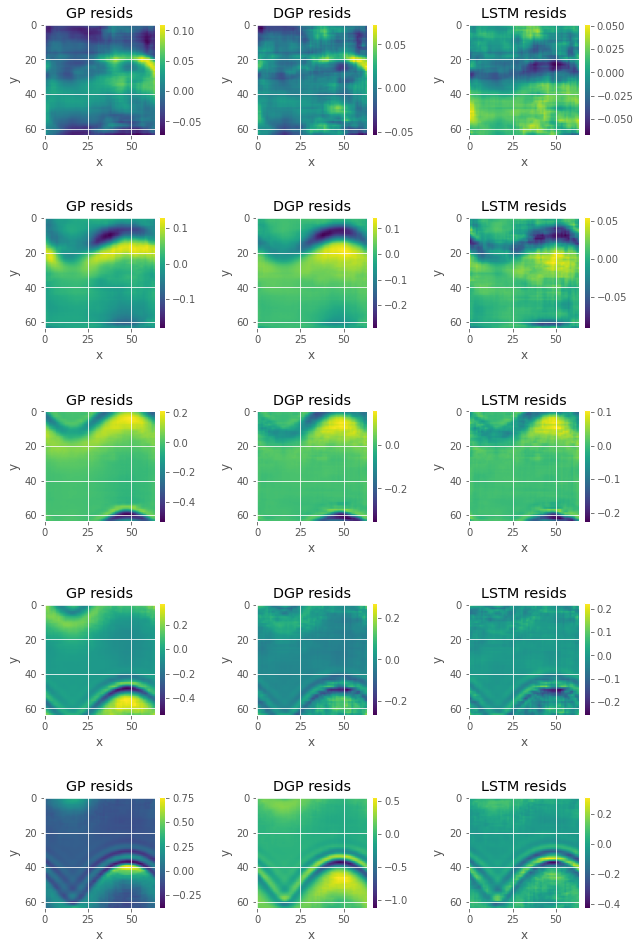

In [44]:
plot_picks = [0, 10, 20, 30, 39]
plot_range = len(plot_picks)

fig = plt.figure(figsize=(9, 15))

for ii, time in enumerate(plot_picks):
    ttime = 10 + time

    full_true = np.load(
        compression + "_data/" + compression + "_True_" + str(ttime) + ".npy"
    )
    dgp_recoded = np.load(
        compression + "_data/" + compression + "_DRec_GP_" + str(ttime) + ".npy"
    )
    gp_recoded = np.load(
        compression + "_data/" + compression + "_Rec_GP_" + str(ttime) + ".npy"
    )

    lstm_recoded = np.load(
        compression + "_data/" + compression + "_lstm_" + str(time) + ".npy"
    )

    dgp_resids = full_true - dgp_recoded
    gp_resids = full_true - gp_recoded
    lstm_resids = full_true - lstm_recoded

    ax = fig.add_subplot(plot_range, 3, 3 * ii + 1)
    cs0 = ax.imshow(gp_resids, label="True")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(cs0, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(f"GP resids")

    ax = fig.add_subplot(plot_range, 3, 3 * ii + 2)
    cs1 = ax.imshow(dgp_resids, label="DGP reconstructed")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(cs1, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(f"DGP resids")

    ax = fig.add_subplot(plot_range, 3, 3 * ii + 3)
    cs2 = ax.imshow(lstm_resids, label="GP reconstructed")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(cs2, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(f"LSTM resids")

    plt.subplots_adjust(wspace=0.5, hspace=-0.3)
    plt.tight_layout()

    plt.savefig(
        "plots/" + compression + "resids.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="w",
    )